# CSE 291 Assignment 2 BiLSTM CRF

## Download Data/Eval Script

In [ ]:
# !wget https://raw.githubusercontent.com/sighsmile/conlleval/master/conlleval.py
# !wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/train.data.quad
# !wget https://raw.githubusercontent.com/tberg12/cse291spr21/main/assignment2/dev.data.quad

In [38]:
import random

import conlleval
from tqdm import tqdm
import numpy as np
from collections import defaultdict, Counter
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torchtext.vocab import vocab
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

torch.manual_seed(291)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [67]:
import matplotlib.pyplot as plt

## Data Preparation

In [40]:
TRAIN_DATA = 'train.data.quad'
VALID_DATA = 'dev.data.quad'
UNK = '<unk>'
PAD = '<pad>'
START_TAG = "<start>"  # you can add this explicitly or use it implicitly in your CRF layer
STOP_TAG = "<stop>"    # you can add this explicitly or use it implicitly in your CRF layer


def read_conll_sentence(path):
    """ Read a CONLL-format sentence into vocab objects
    Args:
        :param path: path to CONLL-format data file
        :param word_vocab: Vocabulary object for source
        :param label_vocab: Vocabulary object for target
    """
    sent = [[], []]
    with open(path) as f:
        for line in f:
            line = line.strip().split()
            if line:
                # replace numbers with 0000
                word = line[0]
                word = '0000' if word.isnumeric() else word
                sent[0].append(word)
                sent[1].append(line[3])
            else:
                yield sent[0], sent[1]
                sent = [[], []]


def prepare_dataset(dataset, word_vocab, label_vocab):
    word_vocab_stoi = word_vocab.get_stoi()
    label_vocab_stoi = label_vocab.get_stoi()
    dataset = [
      [
        torch.tensor([word_vocab_stoi.get(word,0) for word in sent[0]], dtype=torch.long),
        torch.tensor([label_vocab_stoi[label] for label in sent[1]], dtype=torch.long),
      ]
      for sent in dataset
    ]
    random.shuffle(dataset)
    return dataset


# load a list of sentences, where each word in the list is a tuple containing the word and the label
train_data = list(read_conll_sentence(TRAIN_DATA))
train_word_counter = Counter([word for sent in train_data for word in sent[0]])
train_label_counter = Counter([label for sent in train_data for label in sent[1]])
word_vocab = vocab(train_word_counter, specials=(UNK, PAD), min_freq=2)
# print(word_vocab.get_stoi())
# word_vocab.set_default_index(UNK)

label_vocab = vocab(train_label_counter, specials=(), min_freq=1)
train_data = prepare_dataset(train_data, word_vocab, label_vocab)
print('Train word vocab:', len(word_vocab), 'symbols.')
print('Train label vocab:', len(label_vocab), f'symbols: {list(label_vocab.get_stoi().keys())}')

valid_data = list(read_conll_sentence(VALID_DATA))
valid_data = prepare_dataset(valid_data, word_vocab, label_vocab)
print('Train data:', len(train_data), 'sentences.')
print('Valid data:', len(valid_data))

Train word vocab: 3947 symbols.
Train label vocab: 8 symbols: ['B-ORG', 'I-LOC', 'I-PER', 'O', 'I-MISC', 'B-LOC', 'B-MISC', 'I-ORG']
Train data: 3420 sentences.
Valid data: 800


In [43]:
print(' '.join([word_vocab.get_itos()[i.item()] for i in train_data[0][0]]))
print(' '.join([label_vocab.get_itos()[i.item()] for i in train_data[0][1]]))

print(' '.join([word_vocab.get_itos()[i.item()] for i in valid_data[1][0]]))
print(' '.join([label_vocab.get_itos()[i.item()] for i in valid_data[1][1]]))

" There has been some shooting from their side but it has been relatively quiet , " said <unk> <unk> <unk> , a <unk> man wearing a white <unk> and <unk> <unk> .
O O O O O O O O O O O O O O O O O O O I-PER I-PER O O O O O O O O O O O O
The <unk> were held in a house in or near Grozny which was <unk> <unk> .
O O O O O O O O O O I-LOC O O O O O


In [44]:
label_vocab, train_data[6][0], train_data[6][1]

(Vocab(), tensor([77]), tensor([1]))

## BiLSTMTagger

In [95]:
# Starter code implementing a BiLSTM Tagger
# which makes locally normalized, independent
# tag classifications at each time step

class BiLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tag_vocab_size, embedding_dim, hidden_dim, dropout=0.3):
        super(BiLSTMTagger, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tagset_size = tag_vocab_size
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim).to(device)
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True, batch_first=True).to(device)
        self.tag_projection_layer = nn.Linear(hidden_dim, self.tagset_size).to(device)
        # ^ linear layer otherwise known as output embedding layer, which has the dimension same as the number of tags
        # Each entry (which is a logit f) in self.tag_projection_layer is how much does the tagger model like particular tag at particular position without worrying about converting to probabilities
        # To get probabilities, you do softmax, but we actually don't need to do it since argmax will give the same answer
        # pytorch cross entropy functional does the whole thing with the logits by itself anyway, -ve log prob etc.
        self.dropout = nn.Dropout(p=dropout)

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def compute_lstm_emission_features(self, sentence):
        hidden = self.init_hidden()
        embeds = self.dropout(self.word_embeds(sentence))
        bilstm_out, hidden = self.bilstm(embeds, hidden)
        bilstm_out = self.dropout(bilstm_out)
        bilstm_f_logits = self.tag_projection_layer(bilstm_out)
        return bilstm_f_logits

    def forward(self, sentence):
        # Only used during inference i.e. in evaluate function, not loss calculation.
        # It is giving the score (max) of the predicted sequence and the predicted sequence (argmax).
        bilstm_f_logits = self.compute_lstm_emission_features(sentence)
        score, tagseq = bilstm_f_logits.max(-1)[0].sum(), bilstm_f_logits.argmax(-1)
        return score, tagseq

    def loss(self, sentence, tags):
        # Loss function for training
        # print("sentence", sentence)
        bilstm_f_logits = self.compute_lstm_emission_features(sentence)
        # print("bilstm_feats", bilstm_f_logits, bilstm_f_logits.view(-1, self.tagset_size))
        # print("tags", tags, tags.view(-1))
        # transform predictions to (n_examples, n_classes) and ground truth to (n_examples)
        loss =  torch.nn.functional.cross_entropy(
              bilstm_f_logits.view(-1, self.tagset_size),  # n_words_in_sentence x n_tags
              tags.view(-1), # correct tag
              reduction='sum' # add for all words in the sentence
            )
        return loss

## Train / Eval loop

In [96]:
def train(model, train_data, valid_data, word_vocab, label_vocab, epochs, log_interval=25):
    train_losses_per_epoch = []
    mean_train_losses_per_epoch = []
    mean_valid_losses_per_epoch = []
    valid_eval_results = []
    label_vocab_itos = label_vocab.get_itos()
    word_vocab_itos = word_vocab.get_itos()
    for epoch in range(epochs):
        print(f'\n--- EPOCH {epoch} ---')
        model.train()
        train_losses_per_epoch.append([])
        c = 100
        for i, (sent, tags) in enumerate(train_data):
            # print("sent, tags", sent, tags)
            model.zero_grad() # set prev gradients to 0
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            # print(sent, [word_vocab_itos[i] for i in sent[0]])
            # print(sent, [label_vocab_itos[i] for i in tags[0]])
            # print("unsq", sent, tags)
            # print("len input", len(sent[0]))
            loss = model.loss(sent, tags[0])
            loss.backward()
            optimizer.step()
            train_losses_per_epoch[-1].append(loss.detach().cpu().item())
            if i > 0 and i % log_interval == 0:
                mean_loss = np.mean(train_losses_per_epoch[-1][-log_interval:])
                print(f'Avg loss over last {log_interval} updates: {mean_loss}')
            if not c: break
            # c -= 1
        mean_valid_loss, eval_result = evaluate(model, valid_data, word_vocab, label_vocab, log_interval)
        mean_valid_losses_per_epoch.append(mean_valid_loss)
        mean_train_losses_per_epoch.append(np.mean(train_losses_per_epoch[-1]))
        valid_eval_results.append(eval_result)
    return mean_train_losses_per_epoch, train_losses_per_epoch, mean_valid_losses_per_epoch, valid_eval_results


def evaluate(model, dataset, word_vocab, label_vocab, log_interval):
    print("evaluating..")
    model.eval()
    losses = []
    scores = []
    true_tags = []
    pred_tags = []
    sents = []
    label_vocab_itos = label_vocab.get_itos()
    word_vocab_itos = word_vocab.get_itos()
    c = 100
    for i, (sent, tags) in enumerate(dataset):
        with torch.no_grad():
            # print("sent, tags", sent, tags)
            sent, tags = sent.to(device), tags.to(device)
            sent = sent.unsqueeze(0)
            tags = tags.unsqueeze(0)
            # print(sent, [word_vocab_itos[i] for i in sent[0]])
            # print(tags, [label_vocab_itos[i] for i in tags[0]])
            this_loss = model.loss(sent, tags[0]).cpu().detach().item()
            # print("this_loss", this_loss)
            losses.append(this_loss)
            score, pred_tag_seq = model(sent)
            scores.append(score.cpu().detach().numpy())
            true_tags.append([label_vocab_itos[i] for i in tags.tolist()[0]])
            pred_tags.append([label_vocab_itos[i] for i in pred_tag_seq[0]])
            sents.append([word_vocab_itos[i] for i in sent[0]])
        if i > 0 and i%log_interval == 0:
            print("Evaluated", i)
        if not c: break
        # c -= 1

    mean_valid_loss = np.mean(losses)
    print('Avg evaluation loss:', mean_valid_loss)
    eval_result = conlleval.evaluate([tag for tags in true_tags for tag in tags], [tag for tags in pred_tags for tag in tags], verbose=True)
    # print()
    k=2
    print(f'\n{k} random evaluation samples:')
    for i in np.random.randint(0, len(sents), size=k):
        print('SENT:', ' '.join(sents[i]))
        print('TRUE:', ' '.join(true_tags[i]))
        print('PRED:', ' '.join(pred_tags[i]))
    return mean_valid_loss, eval_result

## Training

In [97]:
# Train BiLSTM Tagger Baseline
model = BiLSTMTagger(vocab_size=len(word_vocab), tag_vocab_size=len(label_vocab), embedding_dim=128, hidden_dim=256).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
mean_train_losses_per_epoch, train_losses, valid_losses, valid_evals = train(model, train_data, valid_data, word_vocab, label_vocab, epochs=15, log_interval=500)


--- EPOCH 0 ---
Avg loss over last 500 updates: 8.946532606005668
Avg loss over last 500 updates: 6.682028229528107
Avg loss over last 500 updates: 6.258443628089503
Avg loss over last 500 updates: 6.598942492638249
Avg loss over last 500 updates: 5.418072278042324
Avg loss over last 500 updates: 5.597928476557951
evaluating..
Evaluated 500
Avg evaluation loss:
processed 11170 tokens with 1231 phrases; found: 680 phrases; correct: 439.
accuracy:  40.14%; (non-O)
accuracy:  89.56%; precision:  64.56%; recall:  35.66%; FB1:  45.94
              LOC: precision:  79.03%; recall:  40.16%; FB1:  53.26  186
             MISC: precision:  55.41%; recall:  21.47%; FB1:  30.94  74
              ORG: precision:  59.68%; recall:  36.27%; FB1:  45.12  186
              PER: precision:  59.83%; recall:  38.04%; FB1:  46.51  234

2 random evaluation samples:
SENT: Britain 's <unk> <unk> said on Wednesday he might change his <unk> and go for a fifth consecutive Olympic gold <unk> at the 0000 Games in

In [98]:
torch.save(model, 'model-baseline-latest.pt')

Text(0, 0.5, 'Validation Loss')

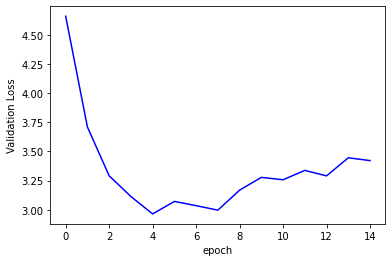

In [99]:
plt.plot(valid_losses, 'b-')
plt.xlabel('epoch')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Training Loss')

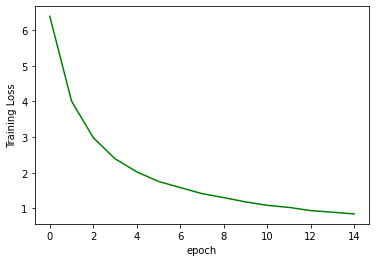

In [100]:
plt.plot(mean_train_losses_per_epoch, 'g-')
plt.xlabel('epoch')
plt.ylabel('Training Loss')

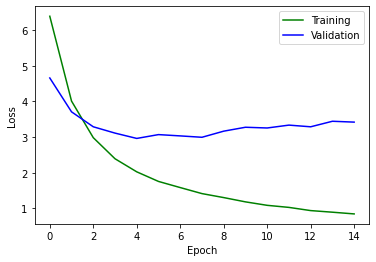

In [104]:
plt.plot(mean_train_losses_per_epoch, 'g-', label='Training')
plt.plot(valid_losses, 'b-', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [105]:
precisions, recalls, f1s = [r[0] for r in valid_evals], [r[1] for r in valid_evals], [r[2] for r in valid_evals]

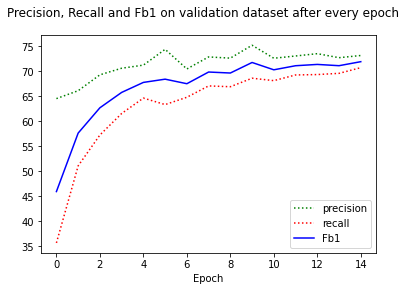

In [118]:
fig, ax1 = plt.subplots()
ax1.plot(precisions, 'g:', label='precision')
ax1.plot(recalls, 'r:', label='recall')
ax1.plot(f1s, 'b', label='Fb1')
ax1.set_xlabel('Epoch')
plt.legend()
plt.suptitle("Precision, Recall and Fb1 on validation dataset after every epoch")
plt.show()

In [150]:
def sampling(model, word_vocab, label_vocab):
    print("example..")
    label_vocab_itos = label_vocab.get_itos()
    word_vocab_itos = word_vocab.get_itos()
    word_vocab_stoi = word_vocab.get_stoi()
    label_vocab_stoi = label_vocab.get_stoi()

    sent, tags = random.choice(valid_data)
    sentence = [word_vocab_itos[i] for i in sent]
    true_tags = [label_vocab_itos[i] for i in tags]
    print('SENT:', ' '.join(sentence))
    print('TRUE:', ' '.join(true_tags))

    sentence = '0000 - British <unk> Alan John <unk> ( <unk> ) Taylor died .'.split()
    sent = torch.tensor([word_vocab_stoi.get(word, 0) for word in sentence], dtype=torch.long)
    print('SENT:', ' '.join(sentence))

    sent = sent.to(device)
    sent = sent.unsqueeze(0)
    score, pred_tag_seq = model(sent)
    pred_tags = [label_vocab_itos[i] for i in pred_tag_seq[0]]

    print('PRED:', ' '.join(pred_tags))
    pass

sampling(model, word_vocab, label_vocab)

example..
SENT: <unk> takes the <unk> on a trial basis , but new coach Glenn Hoddle said he saw no reason why the former Blackburn and <unk> <unk> should not make the post his own .
TRUE: I-PER O O O O O O O O O O O I-PER I-PER O O O O O O O O I-ORG O I-ORG O O O O O O O O O
SENT: 0000 - British <unk> Alan John <unk> ( <unk> ) Taylor died .
PRED: O O I-MISC O I-PER I-PER I-PER O O O I-PER O O
